# Plant Pathology 2020 - FGVC7
---
Identify the category of foliar diseases in apple trees

In [1]:
from fastai2.vision.all import *

## Get the data

In [2]:
path = Path('plant-pathology/data/')
path.ls()

(#5) [Path('plant-pathology/data/train.csv'),Path('plant-pathology/data/.ipynb_checkpoints'),Path('plant-pathology/data/test.csv'),Path('plant-pathology/data/sample_submission.csv'),Path('plant-pathology/data/images')]

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#5) [Path('train.csv'),Path('.ipynb_checkpoints'),Path('test.csv'),Path('sample_submission.csv'),Path('images')]

In [5]:
(path/'images').ls()

(#3642) [Path('images/Test_1746.jpg'),Path('images/Train_711.jpg'),Path('images/Test_1571.jpg'),Path('images/Test_1759.jpg'),Path('images/Train_678.jpg'),Path('images/Test_407.jpg'),Path('images/Train_129.jpg'),Path('images/Test_376.jpg'),Path('images/Test_546.jpg'),Path('images/Train_1704.jpg')...]

## Create Datasets and DataLoaders

In [6]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:
# select the file names
df['image_id']

0          Train_0
1          Train_1
2          Train_2
3          Train_3
4          Train_4
           ...    
1816    Train_1816
1817    Train_1817
1818    Train_1818
1819    Train_1819
1820    Train_1820
Name: image_id, Length: 1821, dtype: object

In [8]:
df['image_id'][0]

'Train_0'

In [9]:
# select only the labels
df.iloc[:,1:]

,healthy,multiple_diseases,rust,scab
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0
...,...,...,...,...
1816,0,0,0,1
1817,1,0,0,0
1818,1,0,0,0
1819,0,0,1,0


Create datablock

In [10]:
db = DataBlock()

In [11]:
ds = db.datasets(df)

In [12]:
ds.train[0]

(image_id             Train_1209
 healthy                       0
 multiple_diseases             0
 rust                          0
 scab                          1
 Name: 1209, dtype: object,
 image_id             Train_1209
 healthy                       0
 multiple_diseases             0
 rust                          0
 scab                          1
 Name: 1209, dtype: object)

In [13]:
def get_x(r): return path/'images'/f'{r["image_id"]}.jpg'
def get_y(r): return list(r.loc[r==1].index)

db = DataBlock(get_x=get_x,
               get_y=get_y)

In [14]:
ds = db.datasets(df)

In [15]:
ds.train[0]

(Path('images/Train_259.jpg'), ['rust'])

Good so now we're getting the right path and labels, let's specify that we're are working with images

In [16]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
               get_x=get_x,
               get_y=get_y)

In [17]:
ds = db.datasets(df)
ds.train[0]

(PILImage mode=RGB size=2048x1365, TensorMultiCategory([1., 0., 0., 0.]))

In [18]:
def get_dls(size, bs):
    db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=size, min_scale=0.75))
    return db.dataloaders(df, bs=bs)

In [23]:
dls = get_dls(128, 128)

Let's have a look at the data

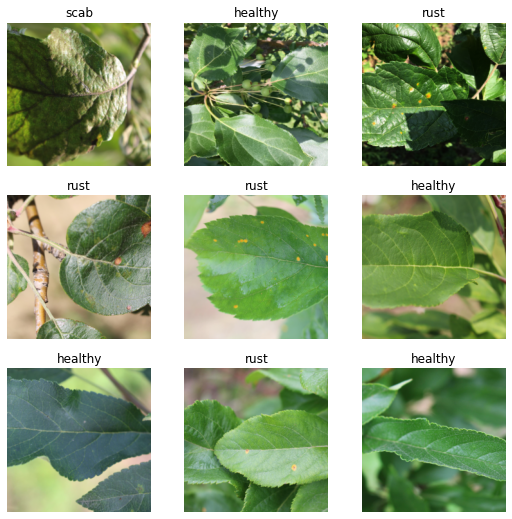

In [20]:
dls.show_batch(max_n=9)

## Build model on 128x128 images

In [24]:
learn = cnn_learner(dls, resnet34,
                    metrics=partial(accuracy_multi, thresh=0.6))

In [25]:
learn.fine_tune(10, freeze_epochs=5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.038166,0.766310,0.647665,00:21
1,0.924535,0.569756,0.770604,00:21
2,0.822597,0.489922,0.824863,00:20
3,0.732438,0.425911,0.857143,00:20
4,0.656099,0.387951,0.881181,00:20


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.424019,0.361832,0.896291,00:21
1,0.407787,0.316145,0.914835,00:21
2,0.366693,0.254415,0.938874,00:19
3,0.324887,0.224586,0.945055,00:20
4,0.289733,0.219563,0.947802,00:21
5,0.255279,0.205292,0.951923,00:20
6,0.227056,0.197551,0.953297,00:21
7,0.206522,0.195216,0.953984,00:21
8,0.188652,0.190240,0.955357,00:20
9,0.173384,0.188485,0.957418,00:20


## Scale up to 224x224 images

In [26]:
dls = get_dls(224, 64)

In [27]:
learn.dls = dls

In [28]:
xb, yb = learn.dls.train.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 4]))

In [29]:
learn.fine_tune(10, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.165419,0.180087,0.942308,00:16
1,0.169145,0.143188,0.953984,00:16
2,0.144510,0.143156,0.960852,00:16


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.109097,0.141335,0.960165,00:16
1,0.097120,0.133149,0.968407,00:16
2,0.085822,0.156143,0.962225,00:16
3,0.083854,0.139754,0.959478,00:16
4,0.069395,0.137875,0.969093,00:16
5,0.060015,0.146896,0.967720,00:16
6,0.051525,0.137149,0.969093,00:16
7,0.042537,0.140452,0.966346,00:16
8,0.035531,0.135388,0.971841,00:17
9,0.029750,0.131858,0.969093,00:16


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.2022644114040304e-05)

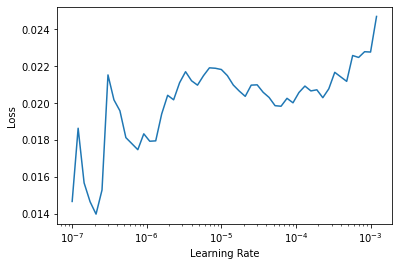

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(10, lr_max=slice(2e-7, 1e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.023886,0.133976,0.971154,00:16
1,0.020588,0.131755,0.971154,00:16
2,0.020994,0.134352,0.971841,00:16
3,0.021887,0.133212,0.970467,00:16
4,0.020791,0.136898,0.970467,00:16
5,0.021098,0.131826,0.971841,00:16
6,0.021440,0.134351,0.971841,00:16
7,0.020988,0.134364,0.973214,00:16
8,0.020503,0.133130,0.969093,00:17
9,0.019677,0.132250,0.970467,00:16


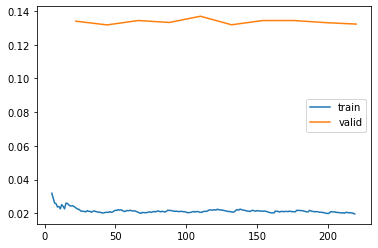

In [32]:
learn.recorder.plot_loss()

## Evaluate on test set

In [33]:
test_df = pd.read_csv(path/'test.csv')
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [34]:
test_dl = learn.dls.test_dl(test_df, with_labels=False)

In [35]:
probs, classes = learn.get_preds(dl=test_dl)

In [36]:
probs.shape

torch.Size([1821, 4])

In [37]:
probs[0]

tensor([7.8713e-04, 8.5649e-03, 9.9997e-01, 1.8935e-04])

In [38]:
probs_df = pd.DataFrame(probs)

In [39]:
probs_df.head()

,0,1,2,3
0,0.000787,0.008565,0.999969,0.000189
1,0.000721,0.001865,0.999929,0.000395
2,0.000056,0.000592,0.000017,1.000000
3,0.999962,0.000601,0.000663,0.000063
4,0.000269,0.000434,1.000000,0.000080


In [40]:
learn.dls.vocab

(#4) ['healthy','multiple_diseases','rust','scab']

In [41]:
probs_df.columns = learn.dls.vocab

In [42]:
probs_df.head()

,healthy,multiple_diseases,rust,scab
0,0.000787,0.008565,0.999969,0.000189
1,0.000721,0.001865,0.999929,0.000395
2,0.000056,0.000592,0.000017,1.000000
3,0.999962,0.000601,0.000663,0.000063
4,0.000269,0.000434,1.000000,0.000080


In [43]:
combined = pd.concat([test_df, probs_df], axis=1)
combined

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000787,0.008565,0.999969,0.000189
1,Test_1,0.000721,0.001865,0.999929,0.000395
2,Test_2,0.000056,0.000592,0.000017,1.000000
3,Test_3,0.999962,0.000601,0.000663,0.000063
4,Test_4,0.000269,0.000434,1.000000,0.000080
...,...,...,...,...,...
1816,Test_1816,0.000426,0.000977,1.000000,0.000052
1817,Test_1817,0.016143,0.942555,0.007906,0.004758
1818,Test_1818,0.004251,0.022348,0.972765,0.000478
1819,Test_1819,0.999193,0.005592,0.001266,0.001558


export predictions to a csv file

In [44]:
combined.to_csv('second.csv', index=False)